### Dimension Reduction Analysis

First run at the combination of embeddings into 2d space for easy visualization. 

* Single dataset (using common API to be easily swapped for any other choice of dataset)
* Group of algorithms
* Analysis of how the algorithms performed vs. each other
    * Visualization of the low dimensional space
    * Comparison via various quality measures
    

In [1]:
import os
from math import ceil

import pandas as pd
import numpy as np
import scipy.stats as stats

from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, Isomap, TSNE

from umap import UMAP

import src
import src.data.datasets as datasets
from src.visualization.plotting import two_dim_multiplot, embeddable_image
import src.quality_measures as qm
import src.embedding_io as e_io
from src.paths import processed_data_path

import logging

LOG_FORMAT = "%(levelname)s %(asctime)s - %(message)s"
DATE_FORMAT = "%m/%d/%Y %I:%M:%S %p"

logging.basicConfig(format=LOG_FORMAT, datefmt=DATE_FORMAT, level=logging.INFO) 
logger = logging.getLogger()

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set(style='white', rc={'figure.figsize':(12,8)})

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# location to save data
if not processed_data_path.exists():
    os.makedirs(processed_data_path)

In [5]:
## To replace with data from the data directory
## Use small sample of MNIST included in sklearn for the toy example
dataset = datasets.load_dataset('coil-20')
dataset_name = 'COIL-20'
metric = 'euclidean'

high_data = dataset.data
labels = dataset.target

print(dataset.DESCR)

INFO 07/12/2018 11:39:09 AM - Checking for coil-20
INFO 07/12/2018 11:39:09 AM - coil-20-proc.tar.gz exists and hash is valid
INFO 07/12/2018 11:39:09 AM - Retrieved Dataset: coil-20 (sha1: e5d518fa9ef1d81aef7dfa24b398e4a509b2ffd5)
INFO 07/12/2018 11:39:09 AM - Extracting coil-20-proc.tar.gz


________________________________________________________________________________
[Memory] Calling src.data.datasets.load_dataset...
load_dataset('coil-20')
________________________________________________________________________________
[Memory] Calling src.data.datasets.load_coil_20...
load_coil_20()
____________________________________________________load_coil_20 - 11.0s, 0.2min
____________________________________________________load_dataset - 11.4s, 0.2min
Columbia University Image Library (COIL-20)

Notes
-----
Data Set Characteristics:
    :Number of Instances: 1440
    :Number of Attributes: 49152
    :Attribute Information: 128x128 8-bit greyscale (PGM) image
    :Missing Attribute Values: None
    :Creator: Sameer A Nene, Shree K. Nayar and Hiroshi Murase
    :Date: 1995

This is a copy of the Columbia Object Image Library [COIL-20] data:
http://www.cs.columbia.edu/CAVE/databases/SLAM_coil-20_coil-100/coil-20/coil-20-proc.tar.gz

This dataset consists of 1,440 greyscale images

## Choice of algorithms to use

Have them all set to use sklearn style API

* PCA
* MDS
* Isomap
* TSNE
* UMAP

In [6]:
low_dimension = 2
random_state = 6502

In [7]:
algorithms = {'PCA' : PCA(n_components=low_dimension, svd_solver='arpack'),
              'MDS' : MDS(n_components=low_dimension, metric=True),
              'tSNE' : TSNE(n_components=low_dimension),
              'Isomap' : Isomap(n_components=low_dimension),
              'UMAP' : UMAP(n_components=low_dimension, metric=metric, random_state=random_state),
             }

The next step takes approximately 
* Small MNIST: 2 minutes
* COIL-20: 8 minutes

In [8]:
processed_data_path.exists()

True

In [9]:
low_data = {}
metadata = {}
for name, algorithm in algorithms.items():
    logger.info(f"Starting {name}")
    basefilename = "_".join([name, dataset_name.replace(' ', '-')])
    low_data[name], _, metadata[name] = e_io.create_embedding(basefilename, data=high_data, 
                                                              algorithm_object=algorithms[name], 
                                                              labels=labels, algorithm_name=name,
                                                              dataset_name=dataset_name,
                                                              data_path=processed_data_path)

INFO 07/12/2018 11:39:20 AM - Starting PCA
INFO 07/12/2018 11:39:20 AM - Existing metatdata file PCA_COIL-20_0.metadata found.
INFO 07/12/2018 11:39:20 AM - Desired embedding already exists. Loading from file...
INFO 07/12/2018 11:39:20 AM - Reading embedding PCA_COIL-20_0.embedding.npy
INFO 07/12/2018 11:39:20 AM - Starting MDS
INFO 07/12/2018 11:39:20 AM - Existing metatdata file MDS_COIL-20_0.metadata found.
INFO 07/12/2018 11:39:20 AM - Desired embedding already exists. Loading from file...
INFO 07/12/2018 11:39:20 AM - Reading embedding MDS_COIL-20_0.embedding.npy
INFO 07/12/2018 11:39:21 AM - Starting tSNE
INFO 07/12/2018 11:39:21 AM - Existing metatdata file tSNE_COIL-20_0.metadata found.
INFO 07/12/2018 11:39:21 AM - Desired embedding already exists. Loading from file...
INFO 07/12/2018 11:39:21 AM - Reading embedding tSNE_COIL-20_0.embedding.npy
INFO 07/12/2018 11:39:21 AM - Starting Isomap
INFO 07/12/2018 11:39:21 AM - Existing metatdata file Isomap_COIL-20_0.metadata found.


## Visualization of the Embeddings

In [10]:
data = []
labels_list = [labels] * len(low_data)
titles = []

for k, v in low_data.items():
    data.append(v)
    titles.append(k)

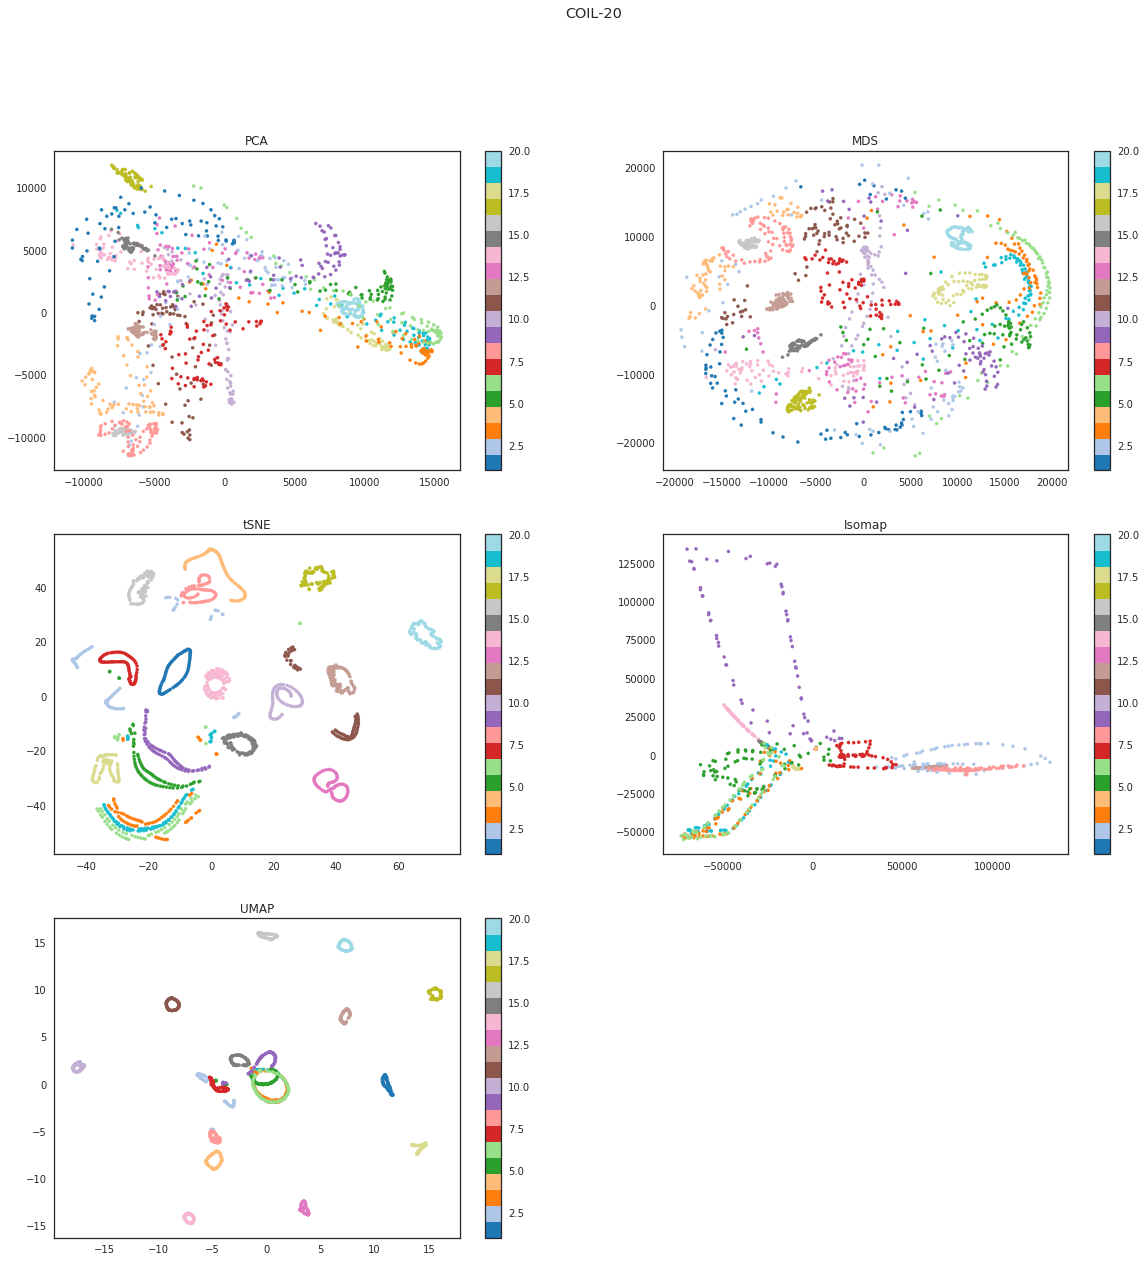

In [11]:
sns.set(style='white', rc={'figure.figsize':(20,20)})
two_dim_multiplot(data, labels_list, titles, ncols=2, cmap="tab20", s=10, share_cbar=False)
plt.suptitle(dataset_name);

## Analysis via quality scores

Start by getting pairwise distances needed for both Stress and Strain.

In [12]:
high_distances = pairwise_distances(high_data, metric=metric)

In [13]:
%%time
low_distances_dict = {}
for name, data in low_data.items():
    _, low_distances, _ = qm.pairwise_distance_differences(high_distances=high_distances,
                                                           low_data=data, metric=metric)
    low_distances_dict[name] = low_distances

CPU times: user 216 ms, sys: 370 ms, total: 586 ms
Wall time: 190 ms


### Strain from Classical MDS
Strain is the name given to stress that is optimized in classical MDS. The optimal solution is given by PCA.

$$\textstyle Strain_{D}(x_{1},x_{2},...,x_{N})={\Biggl (}{\frac {\sum _{i,j}{\bigl (}b_{ij}-\langle x_{i},x_{j}\rangle {\bigr )}^{2}}{\sum _{i,j}b_{ij}^{2}}}{\Biggr )}^{1/2}$$

where $B = -\frac{1}{2} J D^{(2)}J$ and $J = I_{N}-{\tfrac  {1}{N}}{\mathbf  {1}}{\mathbf  {1}}^{\top }$ where $\mathbf  {1}$ is the $N$-dimensional vector of 1's. 

#### Note: Only need to change the following two cells to get the analysis using a different quality score

In [14]:
score = 'Strain'

In [15]:
%%time
point_score = {}
total_score = {}
for name, low_distances in low_distances_dict.items():
    point_score[name] = qm.point_strain(high_distances=high_distances, 
                                          low_distances=low_distances,
                                          metric=metric)
    total_score[name] = qm.strain(high_distances=high_distances, 
                                          low_distances=low_distances,
                                          metric=metric)

CPU times: user 5.98 s, sys: 3.06 s, total: 9.03 s
Wall time: 2.41 s


### Visualization of the point score on the same scale
Color represents the value of the contribution of a given point towards the total score

In [16]:
data = []
labels_list = []
titles = []

for k, v in low_data.items():
    data.append(v)
    titles.append(f"{k}\n {score}: {total_score[k]}")
    labels_list.append(point_score[k])

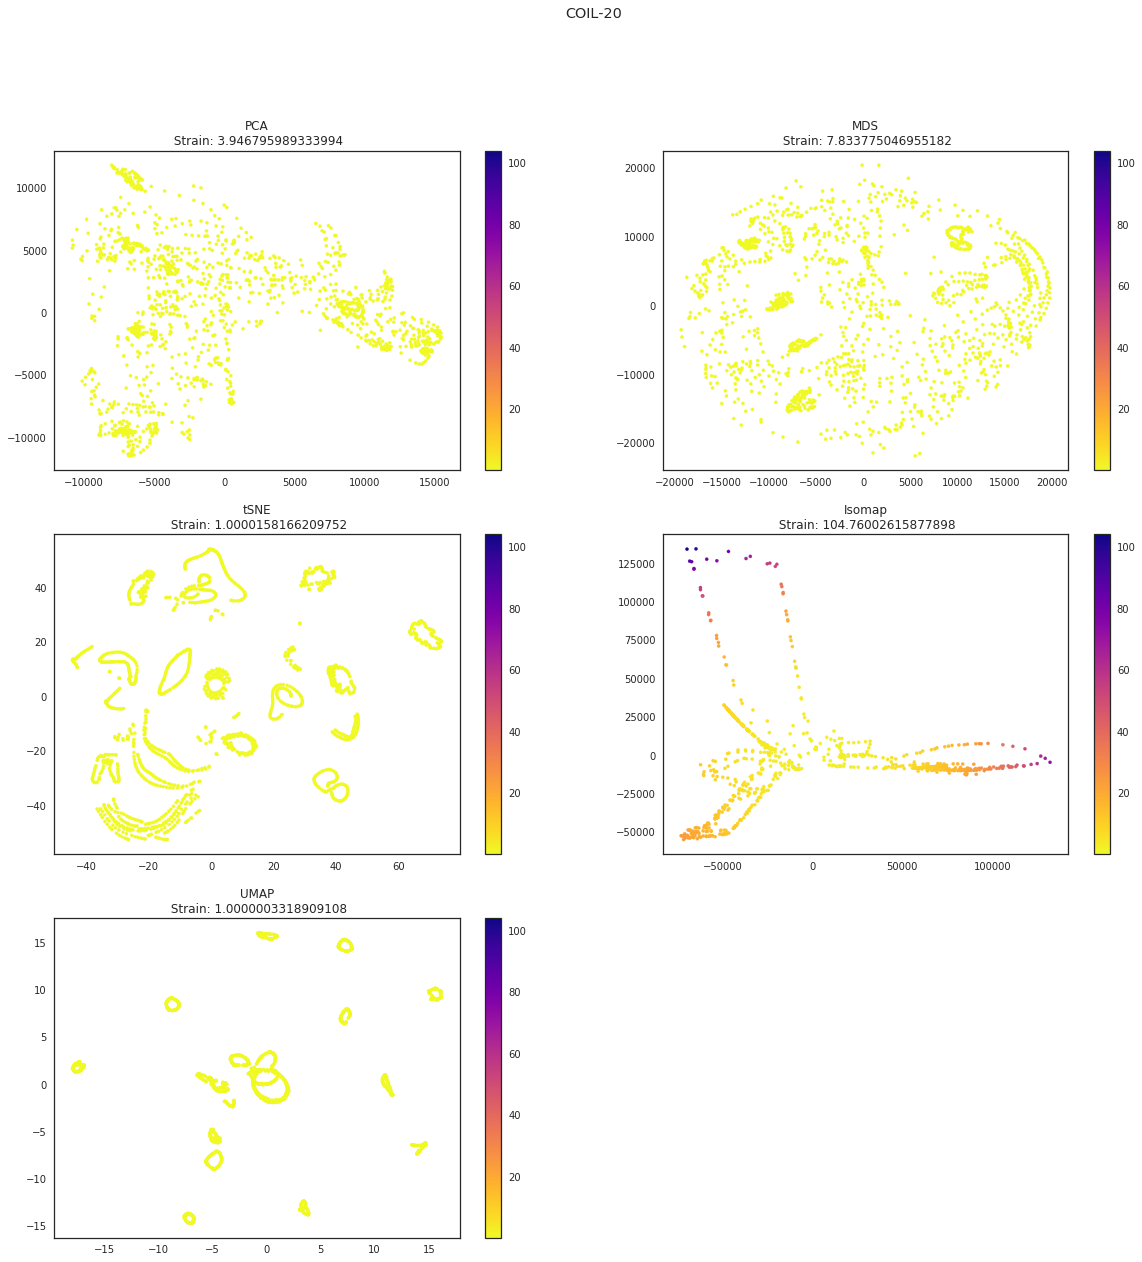

In [17]:
sns.set(style='white', rc={'figure.figsize':(20,20)})

two_dim_multiplot(data, labels_list, titles, ncols=2, cmap="plasma_r", s=10, share_cbar=True)
plt.suptitle(dataset_name);

### How about distributions

In [18]:
point_score_df = pd.DataFrame(point_score)

In [19]:
point_score_df.describe()

,PCA,MDS,tSNE,Isomap,UMAP
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,0.010817,0.042617,0.000694,7.621294,0.000694
std,0.007039,0.021482,0.000426,10.868823,0.000426
min,0.001674,0.007439,0.000064,2.295142,0.000064
25%,0.004944,0.023508,0.000379,2.321296,0.000379
50%,0.009322,0.042062,0.000600,2.926755,0.000600
75%,0.015461,0.057156,0.000901,8.625613,0.000901
max,0.032606,0.105493,0.002036,103.941088,0.002036


/opt/software/anaconda3/envs/dimension_reduction/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/software/anaconda3/envs/dimension_reduction/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/software/anaconda3/envs/dimension_reduction/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/software/anaconda3/envs/dimension_reduction/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg

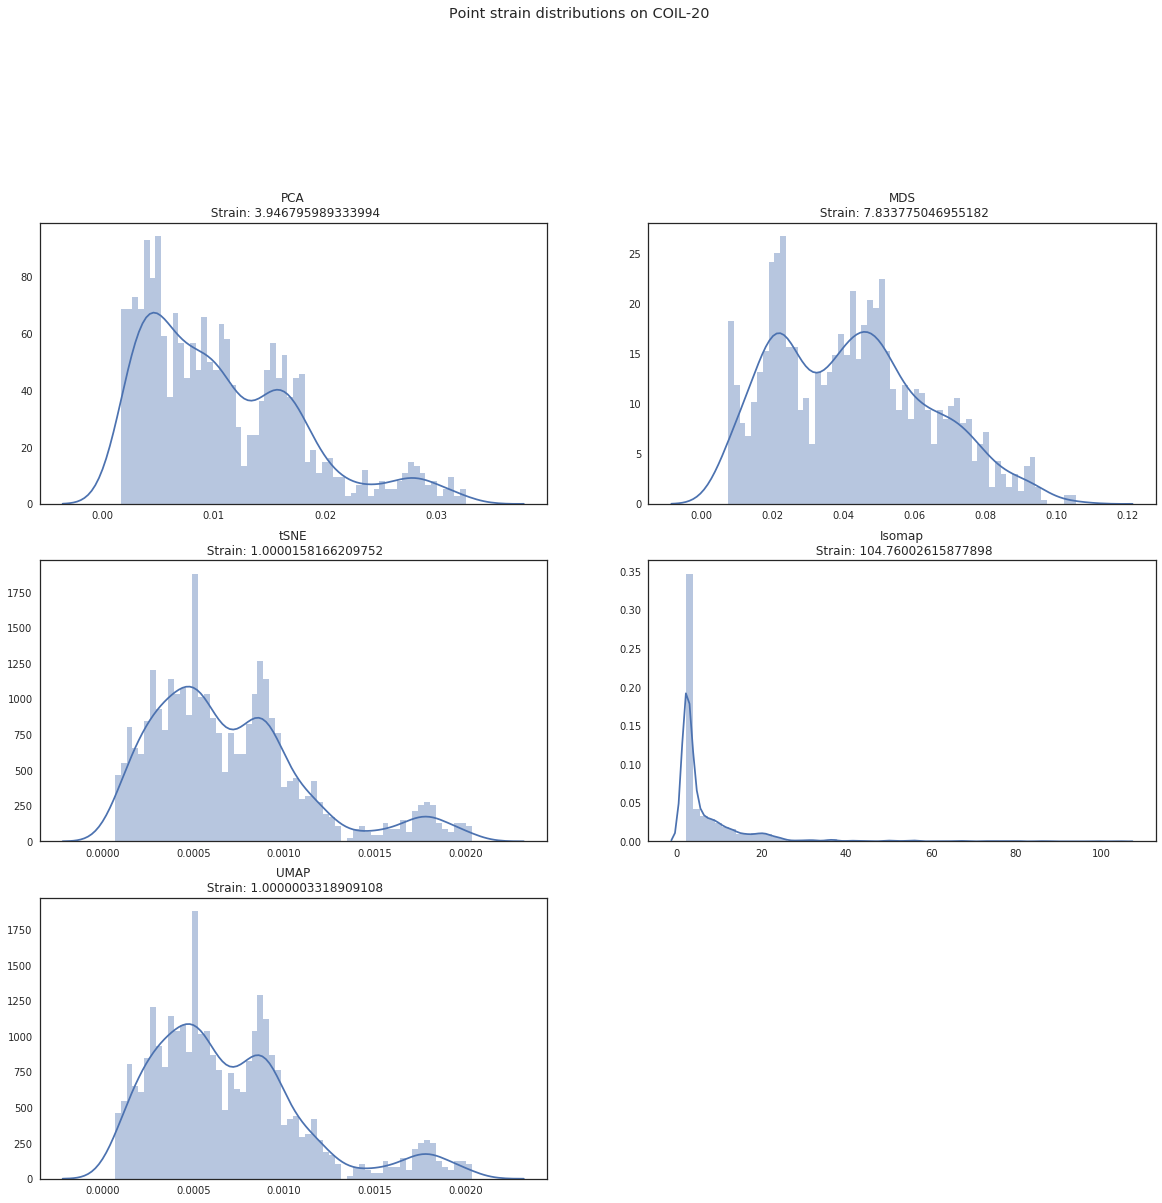

In [20]:
sns.set(style='white', rc={'figure.figsize':(20,30)})

plot_num = 1
ncols = 2
nrows = ceil(len(point_score))

for name, p_score in point_score.items():
    plt.subplot(nrows, ncols, plot_num)
    plot_num += 1
    plt.title(f"{name}\n {score}: {total_score[name]}")
    sns.distplot(p_score, bins=60)
plt.suptitle(f"Point {score.lower()} distributions on {dataset_name}");

### With different colorbar scales

Here we can see where the distrubutions lie with respect to the reduction

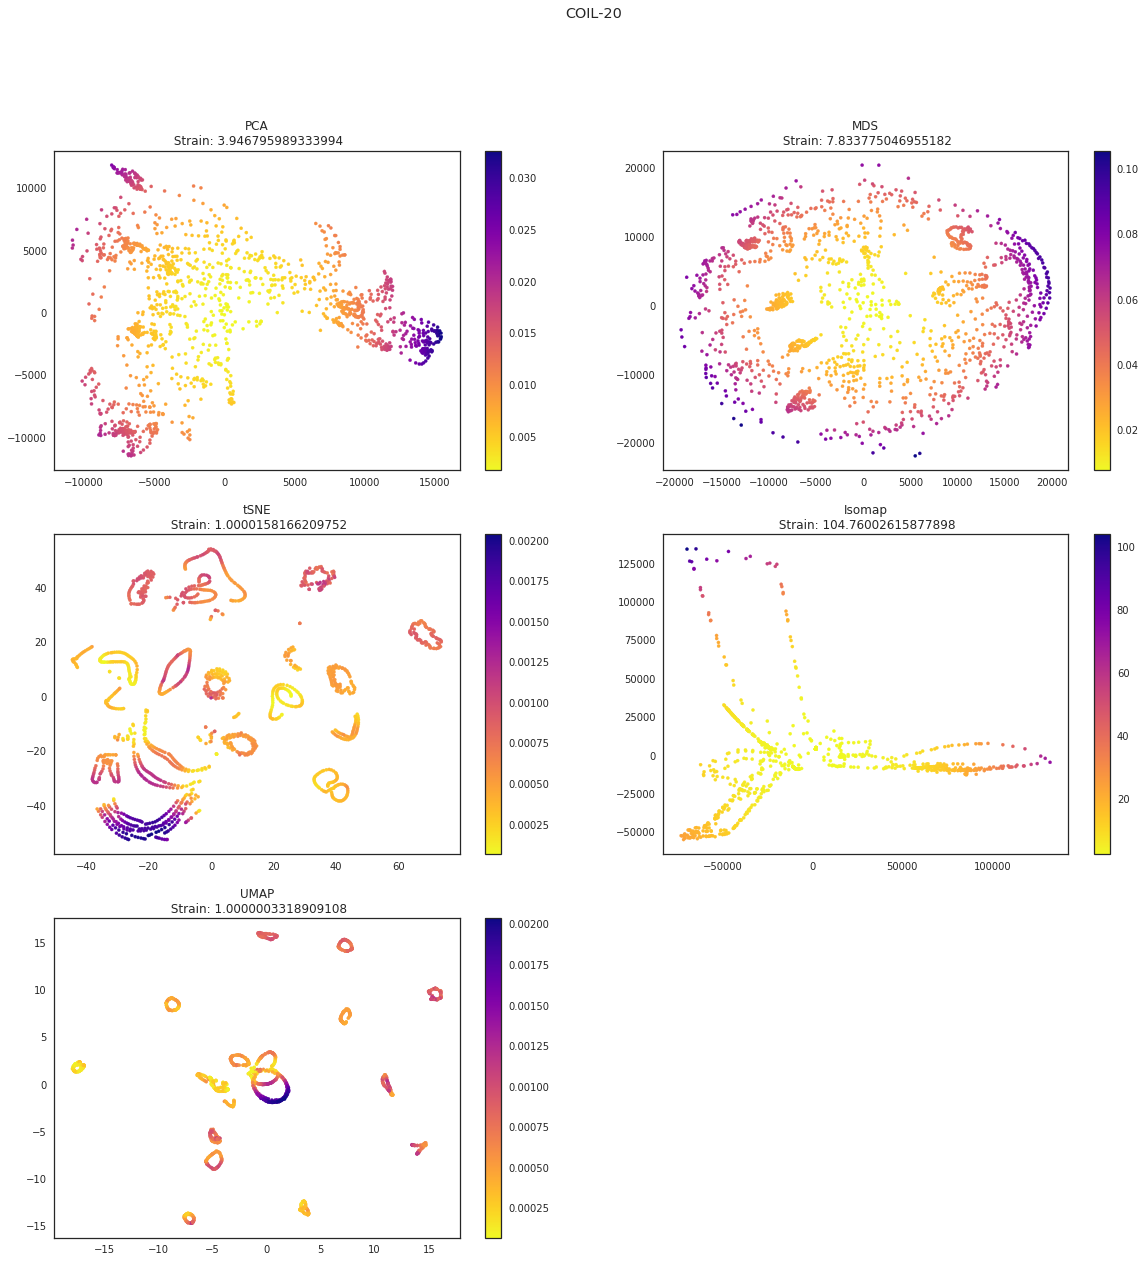

In [21]:
sns.set(style='white', rc={'figure.figsize':(20,20)})

two_dim_multiplot(data, labels_list, titles, ncols=2, cmap="plasma_r", s=10, share_cbar=False)
plt.suptitle(dataset_name);

## Are the same points contributing to the high values in all cases?

In [22]:
n_worst_points = 100

In [23]:
worst_scoring_points = {}
for name, p_score in point_score.items():
    a = point_score_df[name]
    worst_scoring_points[name] = np.argpartition(a, -1 * n_worst_points)[-1 * n_worst_points:]

In [24]:
shared_points_idx = set(point_score_df.index)
for name, worst_points in worst_scoring_points.items():
    shared_points_idx.intersection_update(worst_points)
shared_points_idx = list(shared_points_idx)
len(shared_points_idx)

14

In [25]:
point_score_df.iloc[shared_points_idx]

,PCA,MDS,tSNE,Isomap,UMAP
1184,0.031500,0.093388,0.001983,24.503135,0.001983
1185,0.031237,0.091191,0.001969,22.182830,0.001969
1152,0.031819,0.093463,0.001992,22.979770,0.001992
1153,0.031483,0.093758,0.001975,22.287379,0.001975
966,0.026997,0.077493,0.001738,24.097279,0.001738
967,0.027407,0.077384,0.001758,23.580723,0.001758
968,0.027575,0.078773,0.001768,22.039655,0.001768
969,0.027228,0.078746,0.001751,21.104305,0.001751
937,0.029342,0.079362,0.001847,23.712475,0.001847
1164,0.030882,0.093193,0.001947,22.718174,0.001947


In [26]:
# Note that there is overlap if we take stress instead of strain with COIL-20

## Correlation between high and low distances

In [27]:
total_df = pd.DataFrame(total_score, index = [score]).T
total_df['Name'] = total_df.index
total_df['kendalltau'] = total_df['Name'].apply(lambda x: stats.kendalltau(high_distances.flatten(), low_distances_dict[x].flatten())[0])
total_df['pearsonr'] = total_df['Name'].apply(lambda x: stats.pearsonr(high_distances.flatten(), low_distances_dict[x].flatten())[0])
total_df = total_df.drop('Name', axis=1)
total_df.sort_values('pearsonr')

,Strain,kendalltau,pearsonr
UMAP,1.000000,0.038460,0.133517
Isomap,104.760026,0.157945,0.267558
tSNE,1.000016,0.333598,0.492932
PCA,3.946796,0.613607,0.783791
MDS,7.833775,0.644858,0.809405


/opt/software/anaconda3/envs/dimension_reduction/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/software/anaconda3/envs/dimension_reduction/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


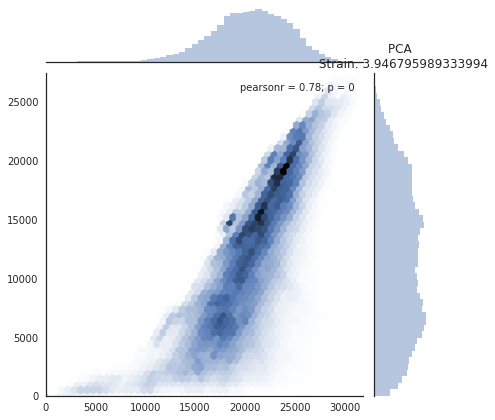

/opt/software/anaconda3/envs/dimension_reduction/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/software/anaconda3/envs/dimension_reduction/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


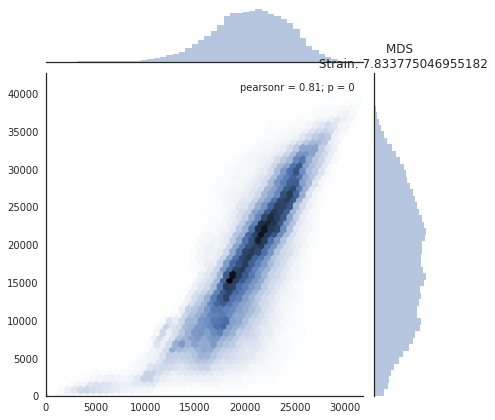

/opt/software/anaconda3/envs/dimension_reduction/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/software/anaconda3/envs/dimension_reduction/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


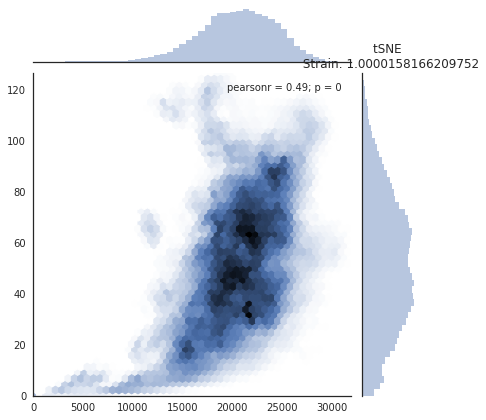

/opt/software/anaconda3/envs/dimension_reduction/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/software/anaconda3/envs/dimension_reduction/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


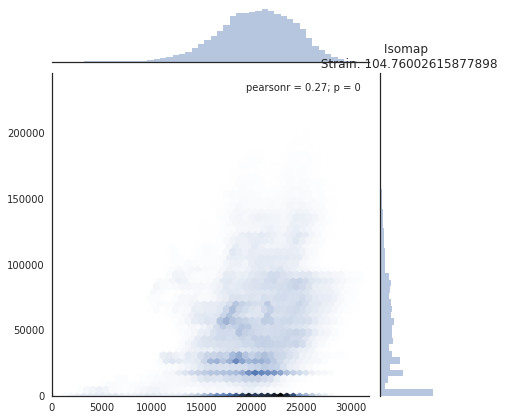

/opt/software/anaconda3/envs/dimension_reduction/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/software/anaconda3/envs/dimension_reduction/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


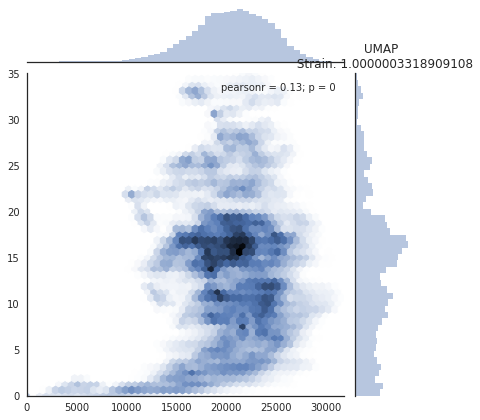

In [28]:
for name in algorithms.keys():
    sns.jointplot(high_distances.flatten(), low_distances_dict[name].flatten(), kind='hex');
    plt.title(f"{name} \n {score}: {total_score[name]}")
    plt.show()

## Strain is not transformation invariant

In [29]:
name = 'Modified Isomap'
low_data[name] = low_data['Isomap']/np.max(abs(low_data['Isomap']))
low_distances_dict[name] = qm.pairwise_distance_differences(high_distances=high_distances,
                                                           low_data=low_data[name], metric=metric)[1]
point_score[name] = qm.point_strain(high_distances=high_distances,
                                          low_distances=low_distances_dict[name],
                                          metric=metric)
total_score[name] = qm.strain(high_distances=high_distances, 
                                          low_distances=low_distances_dict[name],
                                          metric=metric)

In [30]:
data = []
labels_list = []
titles = []

for k in ['Isomap', 'Modified Isomap']:
    v = low_data[k]
    data.append(v)
    titles.append(f"{k}\n {score}: {total_score[k]}")
    labels_list.append(point_score[k])

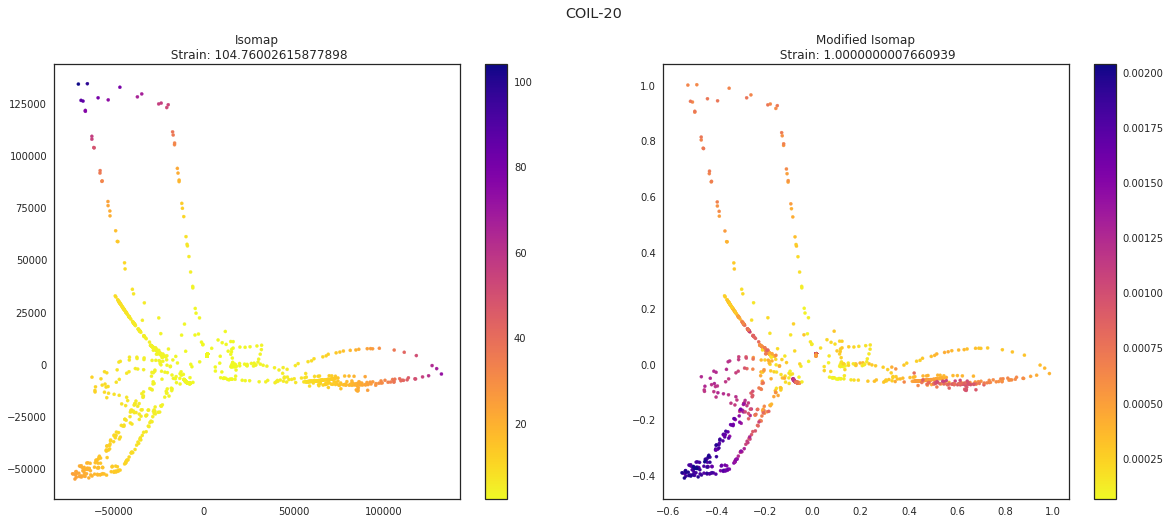

In [31]:
sns.set(style='white', rc={'figure.figsize':(20, 8)})

two_dim_multiplot(data, labels_list, titles, ncols=2, cmap="plasma_r", s=10, share_cbar=False)
plt.suptitle(dataset_name);

In [32]:
total_df = pd.DataFrame(total_score, index = [score]).T
total_df['Name'] = total_df.index
total_df['kendalltau'] = total_df['Name'].apply(lambda x: stats.kendalltau(high_distances.flatten(), low_distances_dict[x].flatten())[0])
total_df['pearsonr'] = total_df['Name'].apply(lambda x: stats.pearsonr(high_distances.flatten(), low_distances_dict[x].flatten())[0])
total_df = total_df.drop('Name', axis=1)
total_df.sort_values('pearsonr')

,Strain,kendalltau,pearsonr
UMAP,1.000000,0.038460,0.133517
Modified Isomap,1.000000,0.157945,0.267558
Isomap,104.760026,0.157945,0.267558
tSNE,1.000016,0.333598,0.492932
PCA,3.946796,0.613607,0.783791
MDS,7.833775,0.644858,0.809405


In [43]:
filepath = processed_data_path / dataset_name / 'png'

In [45]:
from bokeh.plotting import figure, output_file, show, ColumnDataSource, output_notebook
from bokeh.models import CategoricalColorMapper, LabelSet
from bokeh.palettes import d3
#output_notebook()

output_file("toolbar.html")
source_data = dict(
    x=low_data['PCA'][:,0],
    y=low_data['PCA'][:,1],
    label=labels,
    imgs=[embeddable_image(file) for file in filepath.iterdir()]
)

#promote our data frame to a ColumnDataSource for bokeh
source = ColumnDataSource(data=source_data)

# Might have to change this if you have more than 20 categories
# which of the 20 Categorical palette's to use (they vary from length 1 to length 20)
palette = d3['Category20b'][20]
color_map = CategoricalColorMapper(factors=source_data['label'].unique(), palette=palette)
#color_mapper = CategoricalColorMapper(factors=labels.unique(), palette=Category20)


TOOLTIPS = """
    <div>
        <div>
            <img
                src="@imgs" height="42" alt="@imgs" width="42"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
        <div>
            <span style="font-size: 15px; font-weight: bold;">@label</span>
            <span style="font-size: 12px; color: #966;">[@label]</span>
        </div>
        <div>
            <span style="font-size: 15px;">Location</span>
            <span style="font-size: 10px; color: #696;">($x, $y)</span>
        </div>
    </div>
"""

p = figure(plot_width=1200, plot_height=800, tooltips=TOOLTIPS,
           title="Coil 20 Exploration")

#If you want colors to work with circle you must use radius and NOT size
p.circle('x', 'y', 
         line_alpha=0.6,
         fill_alpha=0.6,
         size=6,
         source=source, 
         color={'field': 'label', 'transform': color_map}
        )
show(p)

INFO 07/12/2018 11:44:41 AM - Session output file 'toolbar.html' already exists, will be overwritten.
